Only select the best model

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import random

In [2]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)  # This sets all random seeds in keras
tf.config.experimental.enable_op_determinism()  # For complete reproducibility

In [3]:
def prepare_sequence_data(df):
    """Convert sequences to integer encoding"""
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    
    sequences = df['sequence'].values
    encodings = []
    
    for seq in sequences:
        try:
            integer_encoded = [char_to_int[char] for char in seq]
            encodings.append(integer_encoded)
        except Exception as e:
            print(f"Error processing sequence: {e}")
            continue
    
    return np.array(encodings)

In [5]:
def create_sequence_model():
    """Create CNN model for sequence data"""
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(33,)),
        tf.keras.layers.Embedding(21, 21, input_length=33),
        tf.keras.layers.Reshape((33, 21, 1)),
        tf.keras.layers.Conv2D(32, kernel_size=(17, 3), activation='relu', padding='valid'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [8]:
def train_and_evaluate():
    # Load data
    print("Loading data...")
    train_df = pd.read_csv("../data/processed_data_train.csv")
    test_df = pd.read_csv("../data/processed_data_test.csv")
    
    # Print class distribution
    print("\nClass Distribution:")
    print(train_df['label'].value_counts())
    print(f"\nTrain set size: {len(train_df)}")
    print(f"Test set size: {len(test_df)}")
    
    # Shuffle the training data
    train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Prepare sequence data
    print("\nPreparing sequence data...")
    X_train_seq = prepare_sequence_data(train_df)
    X_test_seq = prepare_sequence_data(test_df)
    
    y_train = train_df['label'].values
    y_test = test_df['label'].values
    
    print(f"Training data shape: {X_train_seq.shape}")
    print(f"Test data shape: {X_test_seq.shape}")
    
    # Calculate class weights
    total_samples = len(y_train)
    pos_samples = np.sum(y_train == 1)
    neg_samples = np.sum(y_train == 0)
    
    class_weights = {
        0: total_samples / (2 * neg_samples),
        1: total_samples / (2 * pos_samples)
    }
    print("\nClass weights:", class_weights)
    
    # Initialize cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Initialize metrics storage and best model tracking
    metrics = {'acc': [], 'balanced_acc': [], 'mcc': [], 'sn': [], 'sp': []}
    best_weights = None
    best_mcc = -1
    
    # Cross-validation loop
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_seq), 1):
        print(f"\n{'='*50}")
        print(f"Fold {fold}/5")
        print('='*50)
        
        # Create callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=3,
                min_lr=1e-6
            )
        ]
        
        # Create and compile model
        model = create_sequence_model()  # Your model creation function
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        # Train model
        print("\nTraining model...")
        history = model.fit(
            X_train_seq[train_idx], y_train[train_idx],
            batch_size=32,
            epochs=50,
            validation_data=(X_train_seq[val_idx], y_train[val_idx]),
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=1
        )
        
        # Plot training history
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Model Accuracy - Fold {fold}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        
        # Evaluate on validation set
        y_pred = model.predict(X_train_seq[val_idx])
        y_pred_binary = (y_pred > 0.5).astype(int)
        
        # Calculate metrics and print confusion matrix
        print(f"\nFold {fold} Validation Results:")
        cm = confusion_matrix(y_train[val_idx], y_pred_binary)
        curr_acc = accuracy_score(y_train[val_idx], y_pred_binary)
        curr_balanced_acc = balanced_accuracy_score(y_train[val_idx], y_pred_binary)
        curr_mcc = matthews_corrcoef(y_train[val_idx], y_pred_binary)
        curr_sn = cm[1][1]/(cm[1][1]+cm[1][0])
        curr_sp = cm[0][0]/(cm[0][0]+cm[0][1])
        
        print(f"Accuracy: {curr_acc:.4f}")
        print(f"Balanced Accuracy: {curr_balanced_acc:.4f}")
        print(f"MCC: {curr_mcc:.4f}")
        print(f"Sensitivity: {curr_sn:.4f}")
        print(f"Specificity: {curr_sp:.4f}")
        print("\nConfusion Matrix:")
        print(f"TN: {cm[0][0]}, FP: {cm[0][1]}")
        print(f"FN: {cm[1][0]}, TP: {cm[1][1]}")
        print(cm)
        
        # Store metrics
        metrics['acc'].append(curr_acc)
        metrics['balanced_acc'].append(curr_balanced_acc)
        metrics['mcc'].append(curr_mcc)
        metrics['sn'].append(curr_sn)
        metrics['sp'].append(curr_sp)
        
        # Save best weights based on MCC
        if curr_mcc > best_mcc:
            best_mcc = curr_mcc
            best_weights = model.get_weights()
            print(f"\nNew best weights saved! (MCC: {curr_mcc:.4f})")
    
    # Print average cross-validation results
    print("\n" + "="*50)
    print("Cross-validation Complete")
    print("="*50)
    print("\nAverage Cross-validation Results:")
    for metric in metrics:
        print(f"{metric.upper()}: {np.mean(metrics[metric]):.4f} ± {np.std(metrics[metric]):.4f}")
    
    # Create final model with best weights
    final_model = create_sequence_model()
    final_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    final_model.set_weights(best_weights)
    
    # Evaluate best model on test set
    print("\n" + "="*50)
    print("Final Test Set Evaluation (Best Model)")
    print("="*50)
    
    test_pred = final_model.predict(X_test_seq)
    test_pred_binary = (test_pred > 0.5).astype(int)
    
    # Calculate and print final test metrics
    cm_test = confusion_matrix(y_test, test_pred_binary)
    print("\nTest Set Results:")
    print(f"Accuracy: {accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"MCC: {matthews_corrcoef(y_test, test_pred_binary):.4f}")
    print(f"Sensitivity: {cm_test[1][1]/(cm_test[1][1]+cm_test[1][0]):.4f}")
    print(f"Specificity: {cm_test[0][0]/(cm_test[0][0]+cm_test[0][1]):.4f}")
    print("\nConfusion Matrix:")
    print(f"TN: {cm_test[0][0]}, FP: {cm_test[0][1]}")
    print(f"FN: {cm_test[1][0]}, TP: {cm_test[1][1]}")
    print(cm_test)
    
    # Save final model
    try:
        final_model.save('best_model')
        print("\nBest model saved as 'best_model'")
    except Exception as e:
        print(f"\nWarning: Could not save model. Error: {str(e)}")
        print("Continuing without saving model...")
    
    return final_model

Loading data...

Class Distribution:
label
1    4591
0    4259
Name: count, dtype: int64

Train set size: 8850
Test set size: 2737

Preparing sequence data...
Training data shape: (8850, 33)
Test data shape: (2737, 33)

Class weights: {0: 1.0389762855130311, 1: 0.9638423001524722}

Fold 1/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2024-12-03 02:34:57.933170: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-12-03 02:34:57.933200: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-03 02:34:57.933207: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-03 02:34:57.933226: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-03 02:34:57.933240: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)



Training model...
Epoch 1/50


2024-12-03 02:34:58.386614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5228 - loss: 0.6925 - val_accuracy: 0.5870 - val_loss: 0.6763 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6211 - loss: 0.6476 - val_accuracy: 0.6627 - val_loss: 0.6106 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7030 - loss: 0.5782 - val_accuracy: 0.6955 - val_loss: 0.5659 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7334 - loss: 0.5383 - val_accuracy: 0.7130 - val_loss: 0.5497 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7612 - loss: 0.5101 - val_accuracy: 0.7141 - val_loss: 0.5456 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7712 - loss: 0.4993 - val_accuracy: 0.7260 - val_loss: 0.5403 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7725 - loss: 0.4835 - val_

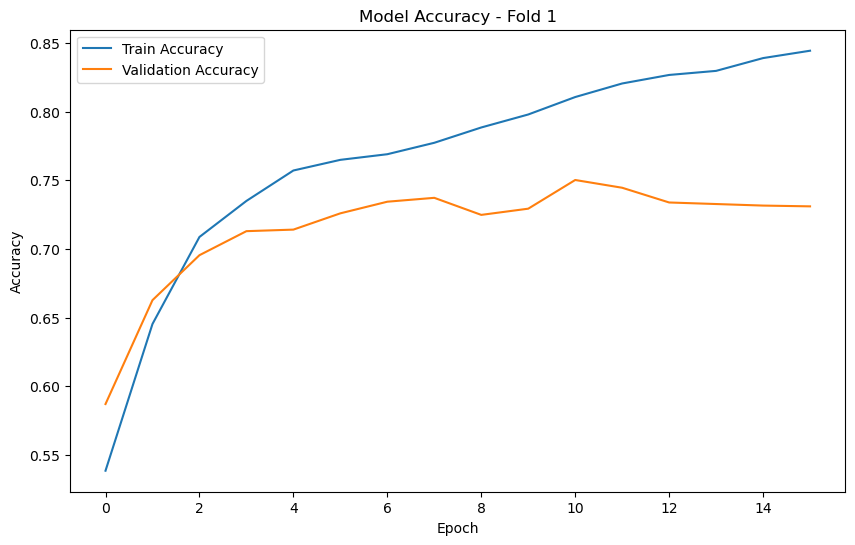

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 1 Validation Results:
Accuracy: 0.7503
Balanced Accuracy: 0.7447
MCC: 0.4945
Sensitivity: 0.8071
Specificity: 0.6824

Confusion Matrix:
TN: 550, FP: 256
FN: 186, TP: 778
[[550 256]
 [186 778]]

New best weights saved! (MCC: 0.4945)

Fold 2/5

Training model...
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5207 - loss: 0.6915 - val_accuracy: 0.6079 - val_loss: 0.6531 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6519 - loss: 0.6304 - val_accuracy: 0.6695 - val_loss: 0.6004 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7052 - loss: 0.5717 - val_accuracy: 0.7209 - val_loss: 0.5447 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7419 - loss: 0.5234 - val_accuracy: 0.7305 - val_loss: 0.5365 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7652 - loss: 0.5041 - val_accuracy: 0.7435 - val_loss: 0.5234 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7734 - loss: 0.4825 - val_accuracy: 0.7407 - val_loss: 0.5237 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7830 - loss: 0.4690 - val_

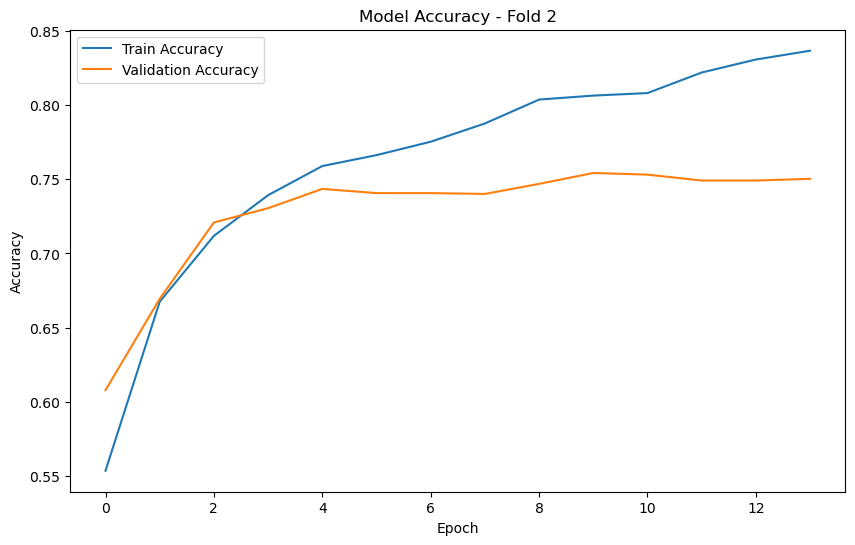

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 2 Validation Results:
Accuracy: 0.7469
Balanced Accuracy: 0.7419
MCC: 0.4919
Sensitivity: 0.8223
Specificity: 0.6614

Confusion Matrix:
TN: 549, FP: 281
FN: 167, TP: 773
[[549 281]
 [167 773]]

Fold 3/5

Training model...
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5002 - loss: 0.6939 - val_accuracy: 0.5847 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.6190 - loss: 0.6564 - val_accuracy: 0.6785 - val_loss: 0.6004 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7054 - loss: 0.5756 - val_accuracy: 0.7158 - val_loss: 0.5579 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7233 - loss: 0.5478 - val_accuracy: 0.7237 - val_loss: 0.5509 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7442 - loss: 0.5236 - val_accuracy: 0.7322 - val_loss: 0.5399 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7589 - loss: 0.5132 - val_accuracy: 0.7379 - val_loss: 0.5360 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7599 - loss: 0.5004 - val_

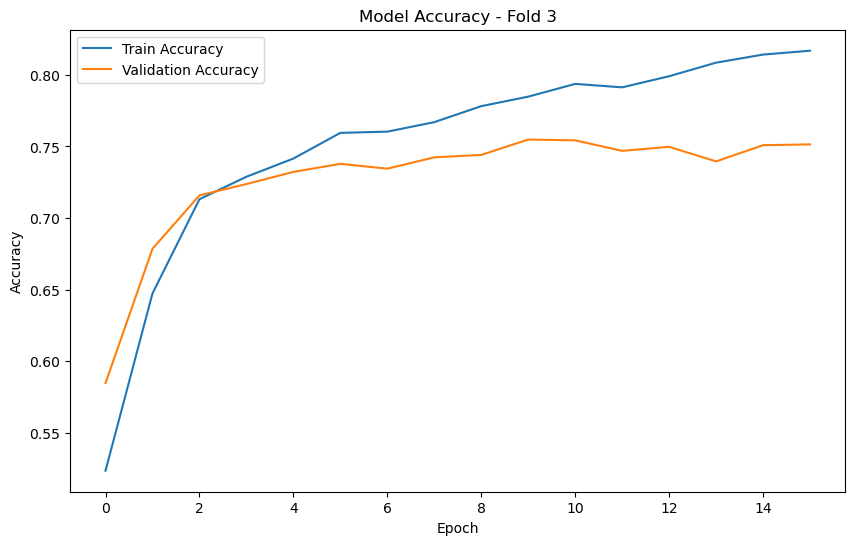

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 3 Validation Results:
Accuracy: 0.7542
Balanced Accuracy: 0.7536
MCC: 0.5124
Sensitivity: 0.8219
Specificity: 0.6853

Confusion Matrix:
TN: 601, FP: 276
FN: 159, TP: 734
[[601 276]
 [159 734]]

New best weights saved! (MCC: 0.5124)

Fold 4/5

Training model...
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5283 - loss: 0.6871 - val_accuracy: 0.6429 - val_loss: 0.6378 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6737 - loss: 0.6172 - val_accuracy: 0.6983 - val_loss: 0.5896 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7087 - loss: 0.5698 - val_accuracy: 0.7316 - val_loss: 0.5475 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7376 - loss: 0.5312 - val_accuracy: 0.7356 - val_loss: 0.5353 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7455 - loss: 0.5146 - val_accuracy: 0.7418 - val_loss: 0.5299 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7592 - loss: 0.4961 - val_accuracy: 0.7328 - val_loss: 0.5345 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7700 - loss: 0.4829 - val_

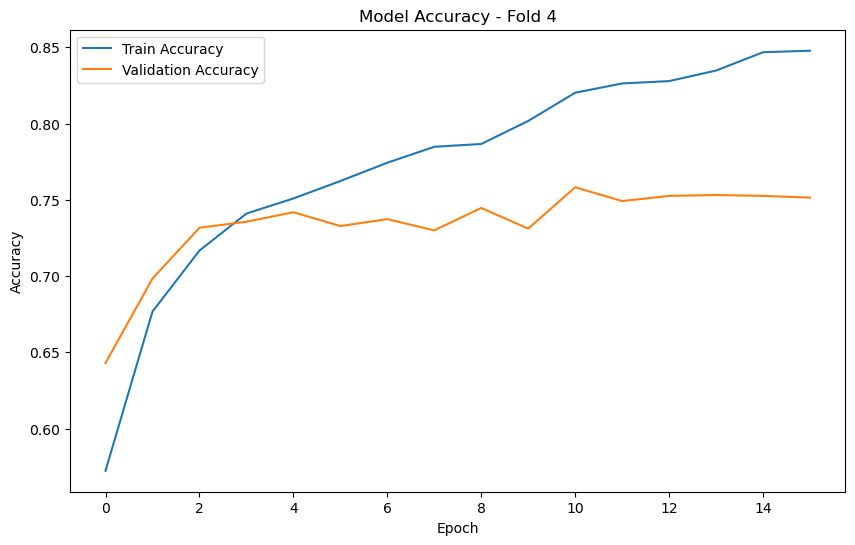

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 4 Validation Results:
Accuracy: 0.7582
Balanced Accuracy: 0.7585
MCC: 0.5184
Sensitivity: 0.7986
Specificity: 0.7183

Confusion Matrix:
TN: 640, FP: 251
FN: 177, TP: 702
[[640 251]
 [177 702]]

New best weights saved! (MCC: 0.5184)

Fold 5/5

Training model...
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5152 - loss: 0.6921 - val_accuracy: 0.6186 - val_loss: 0.6566 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6422 - loss: 0.6418 - val_accuracy: 0.6915 - val_loss: 0.5911 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6906 - loss: 0.5848 - val_accuracy: 0.7220 - val_loss: 0.5589 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7301 - loss: 0.5464 - val_accuracy: 0.7288 - val_loss: 0.5467 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7451 - loss: 0.5271 - val_accuracy: 0.7294 - val_loss: 0.5373 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7535 - loss: 0.5089 - val_accuracy: 0.7333 - val_loss: 0.5361 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7676 - loss: 0.5013 - val_

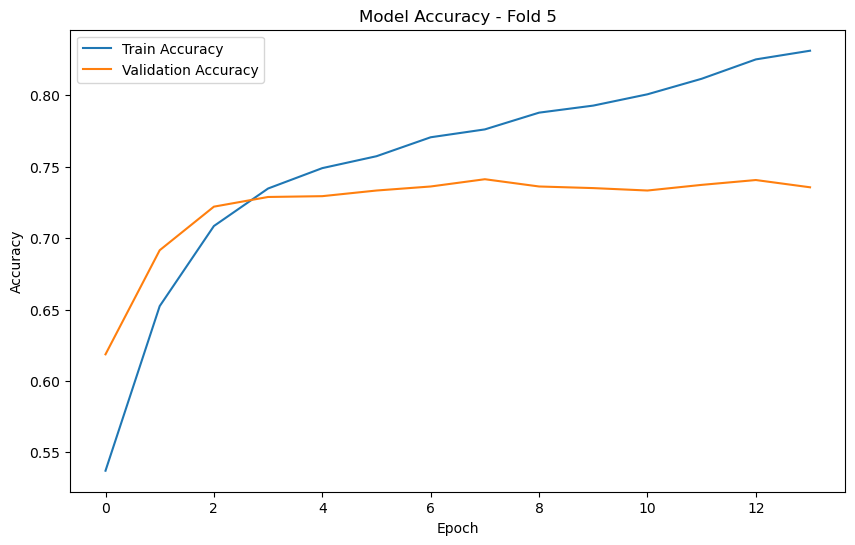

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 5 Validation Results:
Accuracy: 0.7362
Balanced Accuracy: 0.7357
MCC: 0.4716
Sensitivity: 0.7497
Specificity: 0.7216

Confusion Matrix:
TN: 617, FP: 238
FN: 229, TP: 686
[[617 238]
 [229 686]]

Cross-validation Complete

Average Cross-validation Results:
ACC: 0.7492 ± 0.0075
BALANCED_ACC: 0.7469 ± 0.0082
MCC: 0.4978 ± 0.0166
SN: 0.7999 ± 0.0267
SP: 0.6938 ± 0.0229

Final Test Set Evaluation (Best Model)
28/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Test Set Results:
Accuracy: 0.6957
Balanced Accuracy: 0.7390
MCC: 0.2825
Sensitivity: 0.7917
Specificity: 0.6864

Confusion Matrix:
TN: 1714, FP: 783
FN: 50, TP: 190
[[1714  783]
 [  50  190]]

Continuing without saving model...


In [9]:
if __name__ == "__main__":
    model = train_and_evaluate()